### 아마존 리뷰 데이터를 사용한 텍스트 요약 모델 만들기
- 자연어 전처리를 한 후 모델을 훈련한 코드

In [1]:
# !pip install evaluate rouge_score absl-py

In [2]:
import pandas as pd
import re
import contractions
import numpy as np

In [3]:
### 데이터 로드
filename = '../data/Books_ratings_100k.csv'
reviewDF = pd.read_csv(filename)

In [4]:
### 데이터 확인 (결측치 없음)
reviewDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   review/summary  100000 non-null  object
 1   review/text     100000 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [5]:
### 데이터 확인 (랜덤으로 샘플 10개씩 추출)
reviewDF.sample(10)

,review/summary,review/text
56832,"A wonderful, intense, moving experience",This is one of the best books that I have ever...
2118,The Scarlet Letter,Nathaniel Hawthorne's The Scarlet Letter is pr...
41654,The Great Williams lesser knows gems,How beautiful is Tennessee Williams? Consider ...
78928,Paise Jah you people!,This is an excellent translation. The translat...
29409,Ick,I was forced to read this poor excuse for a bo...
8159,A must read if you want to save your money fro...,Written in a conversational style with plenty ...
69308,Maine at his best,An extraordinary tale. David Maine proves to b...
78672,I like it,Great! This is a good item and it will be use ...
41512,Amazing Gift for Any Golfer,The photographs are amazing. They are witty an...
22405,An excellent aid,"As a seminary student, I bought this book on r..."


In [6]:
### frac : 전체 데이터 중 얼마나 사용할 것인지 (1만 개만 사용 => frac=0.1)
### 60%, 20%, 20% 로 데이터 분할
train, valid, test = np.split(
    reviewDF.sample(frac=0.1, random_state=42), [int(0.06 * len(reviewDF)), int(0.08 * len(reviewDF))]
)

In [7]:
len(train), len(valid), len(test)

(6000, 2000, 2000)

In [8]:
### 344개 조합 (축약어, 슬랭)
len(contractions.contractions_dict.keys())

344

In [9]:
contractions.fix("I've known that.")

'I have known that.'

In [10]:
def str_preprocessing(x: str):
    ### str이 아니면 그냥 반환
    if not isinstance(x, str): 
        return x
    
    ### 소문자로 변환
    x = x.lower()

    ### 소괄호로 둘러싸인 문자열 삭제
    pattern1 = r'\([^)]*\)'
    x = re.sub(pattern1, '', x)

    ### 대괄호로 둘러싸인 문자열 삭제
    pattern2 = r'\[[^\]]*\]'
    x = re.sub(pattern2, '', x)

    ### 축약어, 슬랭 처리
    x = contractions.fix(x)

    return x

In [11]:
### 자연어 전처리 수행
train = train.applymap(str_preprocessing)
valid = valid.applymap(str_preprocessing)
test = test.applymap(str_preprocessing)

In [12]:
import torch
from transformers import BartTokenizer
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence

c:\Users\DELL-PC\miniconda3\envs\Text_017_38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def make_dataset(data, tokenizer, device):
    tokenized = tokenizer(  # tokenized : transformers.tokenization_utils_base.BatchEncoding
        text=data['review/text'].tolist(),  # data 안의 text를 list로 변환
        padding="longest",                  # 가장 긴 시퀀스의 길이에 맞춰 패딩을 추가
        truncation=True,                    # 입력 데이터가 모델의 최대입력길이를 초과하는 경우 자르는 작업
        return_tensors="pt",                # 토큰화된 결과를 pytorch tensor로 반환
        max_length=256                      # transformers 4.37.2 에서는 없어도 자동으로 길이고정됨. transformers 4.40.0 에서는 max_length를 줘야 고정됨
    )   # tokenized : 'input_ids', 'attention_mask' 로 구성 (둘 다 tensor이고, shape : [3000, 3913])
    labels = []
    input_ids = tokenized["input_ids"].to(device)
    attention_mask = tokenized["attention_mask"].to(device)
    for target in data['review/summary']:
        ### 요약 문자열을 토큰화, 정수화 하여 텐서로 저장
        labels.append(tokenizer.encode(target, return_tensors="pt").squeeze())
    ### 입력으로 주어진 시퀀스 중 가장 긴 길이에 맞춰서 패딩을 수행한다. (shape : [30])
    labels = pad_sequence(labels, batch_first=True, padding_value=-100).to(device)
    return TensorDataset(input_ids, attention_mask, labels)

def get_datalodader(dataset, sampler, batch_size):
    data_sampler = sampler(dataset)
    dataloader = DataLoader(dataset, sampler=data_sampler, batch_size=batch_size)
    return dataloader

In [14]:
### 에폭, 배치사이즈, 디바이스, 토크나이저
epochs = 100
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BartTokenizer.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
)

In [15]:
type(tokenizer)

transformers.models.bart.tokenization_bart.BartTokenizer

In [16]:
train_dataset = make_dataset(train, tokenizer, device)
train_dataloader = get_datalodader(train_dataset, RandomSampler, batch_size)

valid_dataset = make_dataset(valid, tokenizer, device)
valid_dataloader = get_datalodader(valid_dataset, SequentialSampler, batch_size)

test_dataset = make_dataset(test, tokenizer, device)
test_dataloader = get_datalodader(test_dataset, SequentialSampler, batch_size)

print(train_dataset[0])

(tensor([    0,   271,  4147, 36646,   328,   428, 12807,    42,  1040,    25,
          939,   115,    45,  2067,    13,     5,  1569,     7,    28,   703,
            4,   939,  2333,   109,    45,   101,  4133,   156,    31,  2799,
          734,  6106,   748,   179,  2520,  3260,  1569,    21,    10,  6906,
           13,  4327,     4,  9178,  6294,     6,   143, 19721,     6,  1368,
         9718,    50,    45,     6,    16,   357,    87,    42,  1040,     4,
          405,   362,   162,    81,   727,  6052,     7,   120,   341,     7,
         1236,   922,   324,    18, 13430,     6,  2982,   267, 26427,     6,
            8,   475, 23521,  2496,     4,   939,   888,    21,  2008,     9,
         2185,  2053,   939,   109,    45,  1166,   615,    31,  2182,  7601,
            4,   127,  1623, 17261,   162,     8,    26,    60,  8987,   213,
          356,    23,   110,  2799,   700, 13491,    72,   939,   115,    45,
         1413,    69,  2410,  2496,     4,    79,    16,    45,

In [17]:
x, y, z = train_dataset[0]
print(x.shape)  
print(y.shape)
print(z.shape)

torch.Size([256])
torch.Size([256])
torch.Size([38])


In [18]:
x, y, z = valid_dataset[0]
print(x.shape)
print(y.shape)
print(z.shape)

torch.Size([256])
torch.Size([256])
torch.Size([40])


In [19]:
x, y, z = test_dataset[0]
print(x.shape)
print(y.shape)
print(z.shape)

torch.Size([256])
torch.Size([256])
torch.Size([30])


In [20]:
from torch import optim
from transformers import BartForConditionalGeneration


model = BartForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path="facebook/bart-base"
).to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, eps=1e-8)

In [21]:
for main_name, main_module in model.named_children():
    print(main_name)
    for sub_name, sub_module in main_module.named_children():
        print("└", sub_name)
        for ssub_name, ssub_module in sub_module.named_children():
            print("│  └", ssub_name)
            for sssub_name, sssub_module in ssub_module.named_children():
                print("│  │  └", sssub_name)

model
└ shared
└ encoder
│  └ embed_tokens
│  └ embed_positions
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  └ layernorm_embedding
└ decoder
│  └ embed_tokens
│  └ embed_positions
│  └ layers
│  │  └ 0
│  │  └ 1
│  │  └ 2
│  │  └ 3
│  │  └ 4
│  │  └ 5
│  └ layernorm_embedding
lm_head


In [22]:
import numpy as np
import evaluate
import rouge_score

In [23]:
def calc_rouge(preds, labels):
    preds = preds.argmax(axis=-1)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    rouge2 = rouge_score.compute(
        predictions=decoded_preds,
        references=decoded_labels
    )
    return rouge2["rouge2"]

In [24]:
def train(model, optimizer, dataloader):
    model.train()
    train_loss, train_rouge = 0.0, 0.0

    for input_ids, attention_mask, labels in dataloader:
        # print(f'input_ids => {input_ids.shape}')
        # print(f'attention_mask => {attention_mask.shape}')
        # print(f'labels => {labels.shape}')
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to("cpu").numpy()
        rouge = calc_rouge(logits, label_ids)
        
        train_loss += loss.item()
        train_rouge += rouge
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    train_rouge = train_rouge / len(dataloader)
    return train_loss, train_rouge

In [25]:
def evaluation(model, dataloader):
    with torch.no_grad():
        model.eval()
        val_loss, val_rouge = 0.0, 0.0

        for input_ids, attention_mask, labels in dataloader:
            outputs = model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )
            logits = outputs.logits
            loss = outputs.loss

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to("cpu").numpy()
            rouge = calc_rouge(logits, label_ids)
            
            val_loss += loss
            val_rouge += rouge

    val_loss = val_loss / len(dataloader)
    val_rouge = val_rouge / len(dataloader)
    return val_loss, val_rouge

In [26]:
from tqdm import tqdm

In [27]:
epoch_logs_path = '../models/progress.txt'
train_list, val_list = [[], []], [[], []]   ## 각각 loss, accuracy 저장

rouge_score = evaluate.load("rouge", tokenizer=tokenizer)
best_loss, best_epoch = 10000, 0

In [28]:
### 학습, 검증 코드
for epoch in tqdm(range(epochs)):
    train_metrics = train(model, optimizer, train_dataloader)
    val_metrics = evaluation(model, valid_dataloader)
    print(f"Epoch {epoch + 1}: Train Loss: {train_metrics[0]:.4f} Val Loss: {val_metrics[0]:.4f} Val Rouge {val_metrics[1]:.4f}")

    for i in range(2):
        train_list[i].append(train_metrics[i])
        val_list[i].append(val_metrics[i])
    
    if val_metrics[0] < best_loss:
        ### val_loss가 best_loss보다 개선되면 저장
        best_loss = val_metrics[0]
        best_epoch = epoch
        torch.save(model.state_dict(), "../models/Best_Bart_Amazon_Books.pt")
        # print("Saved the model weights")
    
    ### 가장 많은 Epoch을 돌린 모델 저장
    torch.save(model.state_dict(), "../models/Latest_Bart_Amazon_Books.pt")

    ### 최신 진행정보 저장
    with open(epoch_logs_path, 'w') as file:
        file.write(str(f'Epoch {epoch} Completed\nBest Epoch : {best_epoch}'))

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\DELL-PC\miniconda3\envs\Text_017_38\lib\site-packages\transformers\models\bart\modeling_bart.py:590: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Epoch 1: Train Loss: 3.3085 Val Loss: 2.8845 Val Rouge 0.0955


  1%|          | 1/100 [01:33<2:34:01, 93.34s/it]

Epoch 2: Train Loss: 2.7997 Val Loss: 2.9061 Val Rouge 0.0975


  2%|▏         | 2/100 [03:02<2:28:54, 91.16s/it]

Epoch 3: Train Loss: 2.4920 Val Loss: 2.9322 Val Rouge 0.0992


  3%|▎         | 3/100 [04:32<2:26:30, 90.63s/it]

Epoch 4: Train Loss: 2.2940 Val Loss: 3.0397 Val Rouge 0.0928


  4%|▍         | 4/100 [06:02<2:24:24, 90.26s/it]

Epoch 5: Train Loss: 2.0164 Val Loss: 3.1164 Val Rouge 0.0978


  5%|▌         | 5/100 [07:32<2:22:43, 90.14s/it]

Epoch 6: Train Loss: 1.7488 Val Loss: 3.2494 Val Rouge 0.0925


  6%|▌         | 6/100 [09:02<2:20:56, 89.97s/it]

Epoch 7: Train Loss: 1.5237 Val Loss: 3.3668 Val Rouge 0.0622


  7%|▋         | 7/100 [10:32<2:19:29, 90.00s/it]

Epoch 8: Train Loss: 1.3223 Val Loss: 3.4500 Val Rouge 0.0638


  8%|▊         | 8/100 [12:02<2:17:57, 89.98s/it]

Epoch 9: Train Loss: 1.1298 Val Loss: 3.5627 Val Rouge 0.0898


  9%|▉         | 9/100 [13:31<2:16:16, 89.85s/it]

Epoch 10: Train Loss: 0.9518 Val Loss: 3.7595 Val Rouge 0.0907


 10%|█         | 10/100 [15:01<2:14:37, 89.75s/it]

Epoch 11: Train Loss: 0.7950 Val Loss: 3.8404 Val Rouge 0.0848


 11%|█         | 11/100 [16:30<2:13:04, 89.71s/it]

Epoch 12: Train Loss: 0.6551 Val Loss: 3.9584 Val Rouge 0.0804


 12%|█▏        | 12/100 [18:00<2:11:38, 89.75s/it]

Epoch 13: Train Loss: 0.5366 Val Loss: 4.1196 Val Rouge 0.0867


 13%|█▎        | 13/100 [19:31<2:10:34, 90.05s/it]

Epoch 14: Train Loss: 0.4390 Val Loss: 4.2066 Val Rouge 0.0824


 14%|█▍        | 14/100 [21:01<2:09:06, 90.08s/it]

Epoch 15: Train Loss: 0.3529 Val Loss: 4.2594 Val Rouge 0.0827


 15%|█▌        | 15/100 [22:31<2:07:31, 90.01s/it]

Epoch 16: Train Loss: 0.2896 Val Loss: 4.3525 Val Rouge 0.0863


 16%|█▌        | 16/100 [24:01<2:05:55, 89.94s/it]

Epoch 17: Train Loss: 0.2406 Val Loss: 4.4520 Val Rouge 0.0792


 17%|█▋        | 17/100 [25:31<2:04:29, 89.99s/it]

Epoch 18: Train Loss: 0.2076 Val Loss: 4.4894 Val Rouge 0.0844


 18%|█▊        | 18/100 [27:00<2:02:47, 89.85s/it]

Epoch 19: Train Loss: 0.1706 Val Loss: 4.5615 Val Rouge 0.0906


 19%|█▉        | 19/100 [28:30<2:01:05, 89.70s/it]

Epoch 20: Train Loss: 0.1540 Val Loss: 4.6887 Val Rouge 0.0836


 20%|██        | 20/100 [29:59<1:59:36, 89.70s/it]

Epoch 21: Train Loss: 0.1332 Val Loss: 4.6695 Val Rouge 0.0894


 21%|██        | 21/100 [31:29<1:58:00, 89.63s/it]

Epoch 22: Train Loss: 0.1208 Val Loss: 4.7369 Val Rouge 0.0894


 22%|██▏       | 22/100 [32:58<1:56:25, 89.56s/it]

Epoch 23: Train Loss: 0.1056 Val Loss: 4.7277 Val Rouge 0.0779


 23%|██▎       | 23/100 [34:28<1:54:59, 89.60s/it]

Epoch 24: Train Loss: 0.0948 Val Loss: 4.8575 Val Rouge 0.0872


 24%|██▍       | 24/100 [35:58<1:53:33, 89.65s/it]

Epoch 25: Train Loss: 0.0883 Val Loss: 4.8324 Val Rouge 0.0840


 25%|██▌       | 25/100 [37:27<1:51:56, 89.55s/it]

Epoch 26: Train Loss: 0.0832 Val Loss: 4.8829 Val Rouge 0.0518


 26%|██▌       | 26/100 [38:57<1:50:29, 89.59s/it]

Epoch 27: Train Loss: 0.0788 Val Loss: 4.9127 Val Rouge 0.0687


 27%|██▋       | 27/100 [40:26<1:49:01, 89.62s/it]

Epoch 28: Train Loss: 0.0755 Val Loss: 4.9441 Val Rouge 0.0794


 28%|██▊       | 28/100 [41:56<1:47:28, 89.56s/it]

Epoch 29: Train Loss: 0.0739 Val Loss: 4.9728 Val Rouge 0.0845


 29%|██▉       | 29/100 [43:25<1:45:59, 89.56s/it]

Epoch 30: Train Loss: 0.0659 Val Loss: 5.0397 Val Rouge 0.0859


 30%|███       | 30/100 [44:55<1:44:27, 89.54s/it]

Epoch 31: Train Loss: 0.0667 Val Loss: 5.0763 Val Rouge 0.0851


 31%|███       | 31/100 [46:24<1:42:56, 89.51s/it]

Epoch 32: Train Loss: 0.0600 Val Loss: 5.0488 Val Rouge 0.0746


 32%|███▏      | 32/100 [47:54<1:41:25, 89.49s/it]

Epoch 33: Train Loss: 0.0555 Val Loss: 5.0730 Val Rouge 0.0709


 33%|███▎      | 33/100 [49:23<1:39:56, 89.50s/it]

Epoch 34: Train Loss: 0.0534 Val Loss: 5.1612 Val Rouge 0.0850


 34%|███▍      | 34/100 [50:53<1:38:24, 89.46s/it]

Epoch 35: Train Loss: 0.0533 Val Loss: 5.1612 Val Rouge 0.0820


 35%|███▌      | 35/100 [52:22<1:36:52, 89.42s/it]

Epoch 36: Train Loss: 0.0544 Val Loss: 5.1653 Val Rouge 0.0819


 36%|███▌      | 36/100 [53:51<1:35:18, 89.35s/it]

Epoch 37: Train Loss: 0.0490 Val Loss: 5.2101 Val Rouge 0.0679


 37%|███▋      | 37/100 [55:21<1:33:47, 89.33s/it]

Epoch 38: Train Loss: 0.0487 Val Loss: 5.2157 Val Rouge 0.0787


 38%|███▊      | 38/100 [56:51<1:32:48, 89.82s/it]

Epoch 39: Train Loss: 0.0502 Val Loss: 5.2615 Val Rouge 0.0603


 39%|███▉      | 39/100 [58:24<1:32:14, 90.72s/it]

Epoch 40: Train Loss: 0.0452 Val Loss: 5.3024 Val Rouge 0.0756


 40%|████      | 40/100 [59:56<1:31:01, 91.03s/it]

Epoch 41: Train Loss: 0.0431 Val Loss: 5.3427 Val Rouge 0.0692


 41%|████      | 41/100 [1:01:28<1:29:47, 91.31s/it]

Epoch 42: Train Loss: 0.0415 Val Loss: 5.3296 Val Rouge 0.0589


 42%|████▏     | 42/100 [1:03:00<1:28:21, 91.40s/it]

Epoch 43: Train Loss: 0.0415 Val Loss: 5.2968 Val Rouge 0.0537


 43%|████▎     | 43/100 [1:04:31<1:26:42, 91.27s/it]

Epoch 44: Train Loss: 0.0379 Val Loss: 5.3655 Val Rouge 0.0660


 44%|████▍     | 44/100 [1:06:01<1:24:55, 90.99s/it]

Epoch 45: Train Loss: 0.0388 Val Loss: 5.3745 Val Rouge 0.0656


 45%|████▌     | 45/100 [1:07:31<1:23:11, 90.75s/it]

Epoch 46: Train Loss: 0.0398 Val Loss: 5.4575 Val Rouge 0.0714


 46%|████▌     | 46/100 [1:09:02<1:21:36, 90.67s/it]

Epoch 47: Train Loss: 0.0393 Val Loss: 5.4761 Val Rouge 0.0754


 47%|████▋     | 47/100 [1:10:32<1:19:59, 90.55s/it]

Epoch 48: Train Loss: 0.0398 Val Loss: 5.4555 Val Rouge 0.0843


 48%|████▊     | 48/100 [1:12:02<1:18:22, 90.44s/it]

Epoch 49: Train Loss: 0.0342 Val Loss: 5.4913 Val Rouge 0.0691


 49%|████▉     | 49/100 [1:13:34<1:17:14, 90.88s/it]

Epoch 50: Train Loss: 0.0355 Val Loss: 5.4459 Val Rouge 0.0655


 50%|█████     | 50/100 [1:15:04<1:15:31, 90.63s/it]

Epoch 51: Train Loss: 0.0348 Val Loss: 5.4627 Val Rouge 0.0583


 51%|█████     | 51/100 [1:16:34<1:13:57, 90.55s/it]

Epoch 52: Train Loss: 0.0322 Val Loss: 5.5054 Val Rouge 0.0705


 52%|█████▏    | 52/100 [1:18:05<1:12:26, 90.55s/it]

Epoch 53: Train Loss: 0.0287 Val Loss: 5.4673 Val Rouge 0.0625


 53%|█████▎    | 53/100 [1:19:35<1:10:51, 90.45s/it]

Epoch 54: Train Loss: 0.0289 Val Loss: 5.5399 Val Rouge 0.0749


 54%|█████▍    | 54/100 [1:21:05<1:09:18, 90.40s/it]

Epoch 55: Train Loss: 0.0278 Val Loss: 5.4927 Val Rouge 0.0773


 55%|█████▌    | 55/100 [1:22:36<1:07:46, 90.38s/it]

Epoch 56: Train Loss: 0.0318 Val Loss: 5.5464 Val Rouge 0.0490


 56%|█████▌    | 56/100 [1:24:06<1:06:14, 90.32s/it]

Epoch 57: Train Loss: 0.0275 Val Loss: 5.5559 Val Rouge 0.0614


 57%|█████▋    | 57/100 [1:25:36<1:04:41, 90.27s/it]

Epoch 58: Train Loss: 0.0290 Val Loss: 5.5772 Val Rouge 0.0630


 58%|█████▊    | 58/100 [1:27:06<1:03:11, 90.28s/it]

Epoch 59: Train Loss: 0.0302 Val Loss: 5.6012 Val Rouge 0.0574


 59%|█████▉    | 59/100 [1:28:37<1:01:47, 90.42s/it]

Epoch 60: Train Loss: 0.0272 Val Loss: 5.5369 Val Rouge 0.0512


 60%|██████    | 60/100 [1:30:08<1:00:23, 90.60s/it]

Epoch 61: Train Loss: 0.0242 Val Loss: 5.6357 Val Rouge 0.0514


 61%|██████    | 61/100 [1:31:39<58:57, 90.71s/it]  

Epoch 62: Train Loss: 0.0275 Val Loss: 5.6417 Val Rouge 0.0580


 62%|██████▏   | 62/100 [1:33:10<57:28, 90.74s/it]

Epoch 63: Train Loss: 0.0277 Val Loss: 5.6392 Val Rouge 0.0504


 63%|██████▎   | 63/100 [1:34:41<56:04, 90.92s/it]

Epoch 64: Train Loss: 0.0248 Val Loss: 5.5964 Val Rouge 0.0440


 64%|██████▍   | 64/100 [1:36:13<54:39, 91.10s/it]

Epoch 65: Train Loss: 0.0237 Val Loss: 5.7339 Val Rouge 0.0530


 65%|██████▌   | 65/100 [1:37:44<53:05, 91.00s/it]

Epoch 66: Train Loss: 0.0286 Val Loss: 5.6310 Val Rouge 0.0478


 66%|██████▌   | 66/100 [1:39:15<51:33, 91.00s/it]

Epoch 67: Train Loss: 0.0299 Val Loss: 5.6419 Val Rouge 0.0424


 67%|██████▋   | 67/100 [1:40:47<50:20, 91.52s/it]

Epoch 68: Train Loss: 0.0248 Val Loss: 5.6620 Val Rouge 0.0654


 68%|██████▊   | 68/100 [1:42:19<48:50, 91.58s/it]

Epoch 69: Train Loss: 0.0180 Val Loss: 5.6524 Val Rouge 0.0645


 69%|██████▉   | 69/100 [1:43:50<47:14, 91.43s/it]

Epoch 70: Train Loss: 0.0170 Val Loss: 5.7737 Val Rouge 0.0674


 70%|███████   | 70/100 [1:45:21<45:41, 91.40s/it]

Epoch 71: Train Loss: 0.0203 Val Loss: 5.8340 Val Rouge 0.0764


 71%|███████   | 71/100 [1:46:52<44:06, 91.26s/it]

Epoch 72: Train Loss: 0.0205 Val Loss: 5.7858 Val Rouge 0.0565


 72%|███████▏  | 72/100 [1:48:24<42:38, 91.37s/it]

Epoch 73: Train Loss: 0.0231 Val Loss: 5.7279 Val Rouge 0.0672


 73%|███████▎  | 73/100 [1:49:55<41:03, 91.25s/it]

Epoch 74: Train Loss: 0.0249 Val Loss: 5.7415 Val Rouge 0.0612


 74%|███████▍  | 74/100 [1:51:26<39:29, 91.13s/it]

Epoch 75: Train Loss: 0.0368 Val Loss: 5.7871 Val Rouge 0.0753


 75%|███████▌  | 75/100 [1:52:57<37:54, 91.00s/it]

Epoch 76: Train Loss: 0.1015 Val Loss: 5.8012 Val Rouge 0.0727


 76%|███████▌  | 76/100 [1:54:28<36:24, 91.01s/it]

Epoch 77: Train Loss: 0.0313 Val Loss: 5.8417 Val Rouge 0.0736


 77%|███████▋  | 77/100 [1:55:58<34:47, 90.75s/it]

Epoch 78: Train Loss: 0.0181 Val Loss: 5.8297 Val Rouge 0.0721


 78%|███████▊  | 78/100 [1:57:28<33:10, 90.50s/it]

Epoch 79: Train Loss: 0.0139 Val Loss: 5.8421 Val Rouge 0.0677


 79%|███████▉  | 79/100 [1:58:58<31:36, 90.32s/it]

Epoch 80: Train Loss: 0.0124 Val Loss: 5.8421 Val Rouge 0.0631


 80%|████████  | 80/100 [2:00:27<30:04, 90.21s/it]

Epoch 81: Train Loss: 0.0146 Val Loss: 5.8417 Val Rouge 0.0766


 81%|████████  | 81/100 [2:01:57<28:32, 90.15s/it]

Epoch 82: Train Loss: 0.0096 Val Loss: 5.8389 Val Rouge 0.0659


 82%|████████▏ | 82/100 [2:03:27<27:01, 90.10s/it]

Epoch 83: Train Loss: 0.0113 Val Loss: 5.9347 Val Rouge 0.0783


 83%|████████▎ | 83/100 [2:04:57<25:29, 89.95s/it]

Epoch 84: Train Loss: 0.0126 Val Loss: 5.8410 Val Rouge 0.0489


 84%|████████▍ | 84/100 [2:06:27<23:58, 89.88s/it]

Epoch 85: Train Loss: 0.0116 Val Loss: 5.8580 Val Rouge 0.0580


 85%|████████▌ | 85/100 [2:07:57<22:28, 89.88s/it]

Epoch 86: Train Loss: 0.0104 Val Loss: 5.8665 Val Rouge 0.0582


 86%|████████▌ | 86/100 [2:09:28<21:02, 90.19s/it]

Epoch 87: Train Loss: 0.0146 Val Loss: 5.8266 Val Rouge 0.0677


 87%|████████▋ | 87/100 [2:10:58<19:32, 90.22s/it]

Epoch 88: Train Loss: 0.0125 Val Loss: 5.9621 Val Rouge 0.0646


 88%|████████▊ | 88/100 [2:12:29<18:04, 90.35s/it]

Epoch 89: Train Loss: 0.0136 Val Loss: 5.8987 Val Rouge 0.0711


 89%|████████▉ | 89/100 [2:13:59<16:34, 90.42s/it]

Epoch 90: Train Loss: 0.0127 Val Loss: 5.9488 Val Rouge 0.0785


 90%|█████████ | 90/100 [2:15:29<15:01, 90.17s/it]

Epoch 91: Train Loss: 0.0125 Val Loss: 5.9629 Val Rouge 0.0766


 91%|█████████ | 91/100 [2:16:58<13:29, 89.92s/it]

Epoch 92: Train Loss: 0.0098 Val Loss: 6.0348 Val Rouge 0.0545


 92%|█████████▏| 92/100 [2:18:28<11:58, 89.82s/it]

Epoch 93: Train Loss: 0.0112 Val Loss: 5.9912 Val Rouge 0.0729


 93%|█████████▎| 93/100 [2:19:57<10:28, 89.74s/it]

Epoch 94: Train Loss: 0.0128 Val Loss: 5.9791 Val Rouge 0.0716


 94%|█████████▍| 94/100 [2:21:27<08:58, 89.74s/it]

Epoch 95: Train Loss: 0.0183 Val Loss: 5.9494 Val Rouge 0.0701


 95%|█████████▌| 95/100 [2:22:57<07:29, 89.88s/it]

Epoch 96: Train Loss: 0.0197 Val Loss: 5.9606 Val Rouge 0.0783


 96%|█████████▌| 96/100 [2:24:28<06:00, 90.08s/it]

Epoch 97: Train Loss: 0.0164 Val Loss: 5.9335 Val Rouge 0.0632


 97%|█████████▋| 97/100 [2:25:58<04:30, 90.03s/it]

Epoch 98: Train Loss: 0.0166 Val Loss: 6.0107 Val Rouge 0.0588


 98%|█████████▊| 98/100 [2:27:28<03:00, 90.14s/it]

Epoch 99: Train Loss: 0.0188 Val Loss: 5.9423 Val Rouge 0.0557


 99%|█████████▉| 99/100 [2:28:59<01:30, 90.43s/it]

Epoch 100: Train Loss: 0.0162 Val Loss: 6.0201 Val Rouge 0.0619


100%|██████████| 100/100 [2:30:31<00:00, 90.32s/it]


In [29]:
### 테스트 결과 출력
test_loss, test_rouge_score = evaluation(model, test_dataloader)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test ROUGE-2 Score : {test_rouge_score:.4f}")

Test Loss : 5.9507
Test ROUGE-2 Score : 0.0655


In [32]:
from transformers import pipeline


summarizer = pipeline(
    task="summarization",
    model=model,    # 모델 설정
    tokenizer=tokenizer,
    max_length=50,  # 입력 텍스트가 짧을 경우, 더 줄여도 된다. (예: 24)
    device="cpu"
)

for index in range(5):
    review_text = test['review/text'].iloc[index]
    summarization = test['review/summary'].iloc[index]
    predicted_summarization = summarizer(review_text)[0]["summary_text"]
    print(f"정답 요약문 : {summarization}")
    print(f"모델 요약문 : {predicted_summarization}\n")

정답 요약문 : grand old space opry
모델 요약문 : a great author with a great collection of short stories.



Your max_length is set to 50, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


정답 요약문 : why are so many people happy on ebay?
모델 요약문 : very good volume, why are so many people happy with it?

정답 요약문 : an all-time favorite.
모델 요약문 : a my favorite book. ransom! high school student wrote a review for it!

정답 요약문 : great product-great price-great service
모델 요약문 : a "late talker" book, great service

정답 요약문 : down and out just east of eden
모델 요약문 : a classic about the human spirit prevailing......recommended for interested readers



In [33]:
### 이 처리를 해야 matplotlib으로 그래프를 그릴 때 에러가 발생하지 않는다.
for i, x in enumerate(val_list[0]):
    val_list[0][i] = val_list[0][i].to("cpu").numpy()

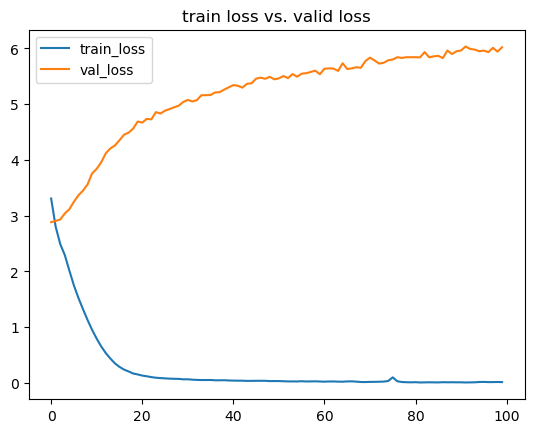

In [34]:
import matplotlib.pyplot as plt

plt.plot(train_list[0], label='train_loss')
plt.plot(val_list[0], label='val_loss')
plt.legend()
plt.title('train loss vs. valid loss')
plt.show()

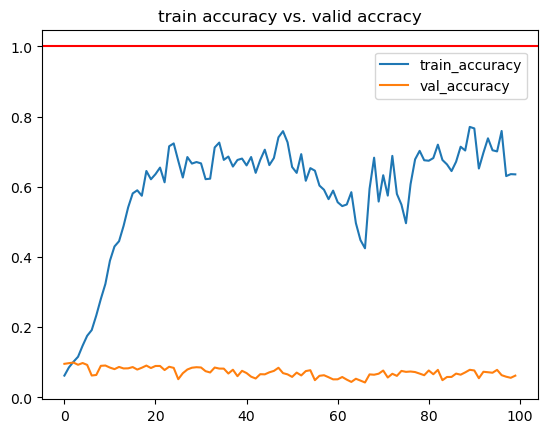

In [35]:
import matplotlib.pyplot as plt

plt.plot(train_list[1], label='train_accuracy')
plt.plot(val_list[1], label='val_accuracy')
plt.axhline(1.0, c='r')
plt.legend(bbox_to_anchor=(0.7, 0.75, 0.25, 0.25), loc='center')
plt.title('train accuracy vs. valid accracy')
plt.show()